In [2]:
import os,sys
final_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
fp2 = os.path.join(final_path, "RESERACH_ASSISTANT")
sys.path.append(fp2)

print("Project root added to path:", fp2)

Project root added to path: /Users/sohombanerjee/Documents/RESERACH_ASSISTANT


In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [5]:
model_loader = ModelLoader()
llm = model_loader.load_llm()

{"timestamp": "2025-11-01T11:06:37.849479Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2025-11-01T11:06:37.851678Z", "level": "info", "event": "OPENAI_API_KEY loaded successfully from environment"}
{"timestamp": "2025-11-01T11:06:37.853604Z", "level": "warning", "event": "GOOGLE_API_KEY is missing in environment variables"}
{"timestamp": "2025-11-01T11:06:37.855489Z", "level": "warning", "event": "GROQ_API_KEY is missing in environment variables"}
{"path": "/Users/sohombanerjee/Documents/RESERACH_ASSISTANT/research_and_analyst/config/configuration.yaml", "keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-01T11:06:37.862627Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-01T11:06:37.863604Z", "level": "info", "event": "YAML configuration loaded successfully"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-

In [6]:
llm.invoke("Who is the president of the United States?")

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='As of my last update, the President of the United States is Joe Biden. He took office on January 20, 2021. Please verify with a current source, as this information may have changed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 16, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CX3jfDcRdkJRkx0Fm49bLPcSd5FZ5', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--829f8a90-0d54-403e-888b-a216b79c38d6-0', usage_metadata={'input_tokens': 16, 'output_tokens': 42, 'total_tokens': 58, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [13]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [114]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [14]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [15]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [20]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [21]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [22]:
def create_analyst(state:GenerateAnalystsState):
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback=state.get("human_analyst_feedback","")
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    structured_llm = llm.with_structured_output(Perspectives)
    analyst = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content=f"Generate the set of analysts.")])
    return {"analysts": analyst.analysts}

    


In [23]:
inp = {"topic": "Finance",
       "max_analysts": 3,
       "human_analyst_feedback": "Focus on economic impacts and market trends."
       }
response = create_analyst(inp)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [24]:
response

{'analysts': [Analyst(name='Dr. Emily Chen', role='Economic Impact Analyst', affiliation='Global Economic Institute', description='Dr. Emily Chen focuses on analyzing the broader economic impacts of financial trends and policies. Her primary concern is understanding how changes in the financial sector affect global economic stability and growth. She is motivated by a desire to provide insights that can help policymakers make informed decisions to foster sustainable economic development.'),
  Analyst(name='Michael Thompson', role='Market Trends Analyst', affiliation='Thompson Financial Analytics', description='Michael Thompson specializes in identifying and interpreting market trends within the finance sector. His focus is on understanding the drivers behind market movements and predicting future trends. He is particularly concerned with how technological advancements and geopolitical events influence market dynamics. His motive is to equip investors and businesses with the knowledge to

In [25]:
def human_feedback(state):
    "No output Node that shoud be interrupted for human feedback"
    pass

In [67]:
def should_continue(state):
    human_analyst_feedback= state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"
    

In [68]:
from IPython.display import Image,display

In [69]:
builder = StateGraph(GenerateAnalystsState)

In [70]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [71]:

builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                               should_continue,
                                ["create_analyst",
                                  END])

In [72]:
memory =MemorySaver()

In [73]:
graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

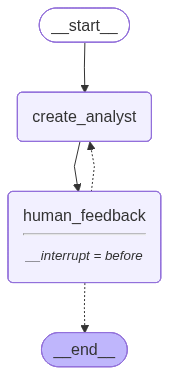

In [74]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [75]:
thread ={"configurable":{"thread_id":1}}

In [76]:
topic =" The benefiits of adapting to Langgraph as an Agentic Framework"
max_analysts=3

In [77]:
for event in graph.stream({
    "topic":topic,
    "max_analysts":max_analysts},
    thread,
    stream_mode="values"):
    analysts= event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute for Advanced Cognitive Studies
Role: Cognitive Scientist
Description: Dr. Chen focuses on the cognitive benefits of adopting Langgraph as an agentic framework. She is particularly interested in how this framework can enhance problem-solving skills and creativity by providing a more structured yet flexible approach to language processing. Her research aims to demonstrate how Langgraph can improve cognitive load management and facilitate better decision-making processes.
--------------------------------------------------
Name: Professor Mark Thompson
Affiliation: Global Education Innovation Network
Role: Educational Technologist
Description: Professor Thompson explores the educational implications of integrating Langgraph into learning environments. He is concerned with how this framework can be used to develop more interactive and personalized learning experiences. His work is motivated by the potential of Langgraph to support adaptive learnin

## How to use Human Feedbck
--> We update the state.next-> human input that actually updates the humnan feedback

In [78]:
state = graph.get_state(thread)

In [79]:
state.next

('human_feedback',)

In [80]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b71d4-2690-6d9e-8001-27645f535941'}}

In [81]:
graph.update_state(
    thread,
    {"human_analyst_feedback": "add something from the startup perspective and focus on the latest enterprise application"},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b71d4-5987-6112-8002-9f84003b7de0'}}

In [82]:
# inspect node keys to see whether they are strings or callables
print(list(graph.nodes.keys()))   # or alternative API if available

['__start__', 'create_analyst', 'human_feedback']


In [83]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Institute for Advanced Cognitive Studies
Role: Cognitive Scientist
Description: Dr. Chen focuses on the cognitive benefits of adopting Langgraph as an agentic framework. She is particularly interested in how this framework can enhance problem-solving skills and creativity by providing a more structured yet flexible approach to language processing. Her research aims to demonstrate how Langgraph can improve cognitive load management and facilitate better decision-making processes.
--------------------------------------------------
Name: Professor Mark Thompson
Affiliation: Global Education Innovation Network
Role: Educational Technologist
Description: Professor Thompson explores the educational implications of integrating Langgraph into learning environments. He is concerned with how this framework can be used to develop more interactive and personalized learning experiences. His work is motivated by the potential of Langgraph to support adaptive learnin

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Tech Innovators Inc.
Role: Enterprise Technology Strategist
Description: Dr. Chen focuses on the integration of cutting-edge technologies into large-scale enterprise systems. She is particularly interested in how Langgraph can serve as an agentic framework to enhance operational efficiency and decision-making processes within enterprises. Her analysis includes evaluating the latest applications of Langgraph in enterprise environments and its potential to streamline workflows and improve data-driven strategies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Venture Growth Partners
Role: Startup Ecosystem Analyst
Description: Michael specializes in analyzing emerging technologies and their impact on startup ecosystems. He is keen on exploring how Langgraph, as an agentic framework, can provide startups with a competitive edge by enabling more adaptive and scalable solutions. His focus is on the potential for Langgr

## Workflow 2

In [123]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

In [124]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [108]:
docs = WikipediaLoader("LangGraph").load()

In [109]:
print(docs[0].page_content[:100])

LangChain is a software framework that helps facilitate the integration of large language models (LL


In [125]:
tavily_api_key= os.getenv("TAVILY_API_KEY")
tavily_search = TavilySearchResults(api_key=tavily_api_key)

In [111]:
tavily_search.invoke("LangGraph framework")

[{'title': 'LangGraph - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.',
  'score': 0.92507464},
 {'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/python/langgraph/overview',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. LangGraph is very low-level, and focused entirely on agent o

In [126]:
memory =MemorySaver()

In [127]:
from typing import Annotated
import operator
class InterviewState(MessagesState):
    max_turns : int # Number of turns of conversation
    context: Annotated[List,operator.add] # Source documents
    analyst: Analyst # Analyst Asking Questions
    interview: str # The interview transcript
    sections: list # Final key we deduplicate in outer state for send API()

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="The search query .")


In [128]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [130]:
interview_builder = StateGraph(InterviewState)


In [131]:
def genration_question(state:InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    system_message =question_instructions.format(goals=analyst.persona)
    questions = llm.invoke([SystemMessage(content=system_message) ]+ messages)
    
    return {"messages": [questions]}


In [132]:
from langchain_core.messages import get_buffer_string

In [133]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [134]:
def search_web(state:InterviewState):
    # what output is required
    strucured_llm = llm.with_structured_output(SearchQuery)
    # How the input shoud look like should come from the prompt
    # state messqges would hold the questions geneated by last node
    # And now for each question we need to generate a search query
    search_query = strucured_llm.invoke([search_instructions]+ state["messages"])
    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}



In [135]:
def search_wiki(state:InterviewState):
    # what output is required
    strucured_llm = llm.with_structured_output(SearchQuery)
    # How the input shoud look like should come from the prompt
    # state messqges would hold the questions geneated by last node
    # And now for each question we need to generate a search query
    search_query = strucured_llm.invoke([search_instructions]+ state["messages"])

    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

    
    

In [136]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [137]:
def generate_answer(state:InterviewState):
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [138]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer 
    We can end the loop if max number of turns is reached or if the last question signals the end of discussion.
    """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [139]:
def save_interview(state:InterviewState):
    messages = state["messages"]
    interview_transcript = get_buffer_string(messages)
    return {"interview": interview_transcript}

In [140]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [141]:
def write_section(state:InterviewState):
    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

In [142]:
interview_builder.add_node("ask_question",genration_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wiki",search_wiki)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)


In [ ]:
interview_builder.add_edge(START,"ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wiki")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wiki","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                                        route_messages,
                                        ["ask_question",
                                         "save_interview"
                                         ]
                                        )
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [144]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct_interview")

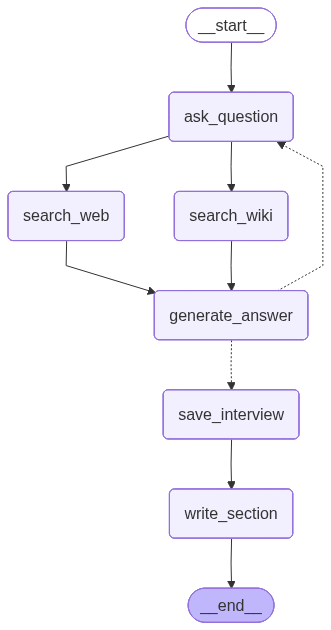

In [ ]:
display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))

In [149]:
human_message=HumanMessage(content="Do the proper reserach according to the expertise")


In [150]:
state ={ "max_num_turns": 2,"analyst":analyst,"interview":"","section":[],"messages":[human_message]}

In [151]:
state

{'max_num_turns': 2,
 'analyst': Analyst(name='Sophia Martinez', role='AI and Machine Learning Specialist', affiliation='FutureTech Labs', description="Sophia's expertise lies in the application of AI and machine learning frameworks. She is interested in how Langgraph can be leveraged to enhance AI models' adaptability and learning capabilities. Her analysis delves into the technical benefits of using Langgraph to improve the performance and scalability of AI systems, particularly in dynamic and complex environments."),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='Do the proper reserach according to the expertise', additional_kwargs={}, response_metadata={})]}

In [153]:
result =genration_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [163]:
result["messages"][0]

AIMessage(content="Hello, Sophia. My name is Alex Johnson, and I'm an analyst interested in the intersection of AI and machine learning frameworks. I'm particularly curious about your work with Langgraph. Could you explain how Langgraph enhances AI models' adaptability and learning capabilities in dynamic environments? \n\nWhat are some specific examples or case studies where Langgraph has significantly improved AI performance?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 254, 'total_tokens': 325, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CX6K1RoZnMEVRtWNRG6ZWiXYsIC7m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8bf8657f-a9af-42ec

## state for web and wikipedia search

In [167]:
state ={ "max_num_turns": 2,"analyst":analyst,"interview":"","section":[],"messages":[AIMessage(content="Hello, Sophia. My name is Alex Johnson, and I'm an analyst interested in the intersection of AI and machine learning frameworks. I'm particularly curious about your work with Langgraph. Could you explain how Langgraph enhances AI models' adaptability and learning capabilities in dynamic environments? \n\nWhat are some specific examples or case studies where Langgraph has significantly improved AI performance?")]}

In [ ]:
web_search_query = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [173]:
print(web_search_query["context"][0])

<Document href="https://www.linkedin.com/pulse/exploring-frontiers-ai-top-5-use-cases-langchain-dileep-kumar-pandiya-hos3e"/>
LangGraph extends LangChain's capabilities by introducing a graph-based approach to workflow orchestration. This allows for more complex and flexible control flows, enabling developers to define intricate decision paths and parallel processing within their AI applications.

Top 5 Use Cases of LangChain and LangGraph

Use Case 1:

Conversational AI with Contextual Awareness: [...] potential and bringing the power of AI to a wider audience. The shift towards graph-based orchestration with LangGraph further emphasizes the growing need for flexible and adaptable AI development tools in the rapidly evolving technological landscape. [...] LangGraph Enhancement: LangGraph can be used to implement more complex agent-based workflows, where different agents collaborate to achieve a common goal. This allows for the creation of more sophisticated and adaptable automation sy

In [170]:
wiki_search_query = search_wiki(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph AI adaptability learning capabilities case studies'


In [172]:
wiki_search_query["context"][0]

''

In [174]:
analyst

Analyst(name='Sophia Martinez', role='AI and Machine Learning Specialist', affiliation='FutureTech Labs', description="Sophia's expertise lies in the application of AI and machine learning frameworks. She is interested in how Langgraph can be leveraged to enhance AI models' adaptability and learning capabilities. Her analysis delves into the technical benefits of using Langgraph to improve the performance and scalability of AI systems, particularly in dynamic and complex environments.")

In [176]:
from IPython.display import Image,display,Markdown

In [177]:
messages = [HumanMessage("So you are an analyst interested in Langgraph?")]

In [178]:
thread ={"configurable":{"thread_id":2}}

In [179]:
analysts

[Analyst(name='Dr. Emily Chen', role='Enterprise Technology Strategist', affiliation='Tech Innovators Inc.', description='Dr. Chen focuses on the integration of cutting-edge technologies into large-scale enterprise systems. She is particularly interested in how Langgraph can serve as an agentic framework to enhance operational efficiency and decision-making processes within enterprises. Her analysis includes evaluating the latest applications of Langgraph in enterprise environments and its potential to streamline workflows and improve data-driven strategies.'),
 Analyst(name='Michael Thompson', role='Startup Ecosystem Analyst', affiliation='Venture Growth Partners', description='Michael specializes in analyzing emerging technologies and their impact on startup ecosystems. He is keen on exploring how Langgraph, as an agentic framework, can provide startups with a competitive edge by enabling more adaptive and scalable solutions. His focus is on the potential for Langgraph to facilitate 

In [181]:
state ={"analyst": analyst,"messages": messages, "max_turns":2}

In [183]:
interview  = interview_graph.invoke(state, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph impact on AI model adaptability and learning capabilities'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph real-world application example AI performance dynamic environment'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [184]:
Markdown(interview["sections"][0])

## Enhancing AI Models with LangGraph: A New Frontier in Machine Learning

### Summary

In the rapidly evolving field of artificial intelligence, the integration of LangGraph presents a significant advancement in enhancing AI models' adaptability and learning capabilities. LangGraph, a framework built on top of Langchain, offers a versatile and robust platform for developing AI agents, enabling them to operate in dynamic and complex environments. This report explores the technical benefits of using LangGraph to improve the performance and scalability of AI systems.

LangGraph's novel approach lies in its ability to construct cyclic graphs for large language model (LLM)-based AI agents, allowing for more nuanced and variable agent behaviors compared to traditional linear execution models [1]. This flexibility is crucial as it enables AI systems to adapt dynamically to different domains or contexts, such as switching from casual to technical translation styles [2]. The framework's adaptability is further enhanced by its robust state management capabilities, which maintain context and coherence in conversations, crucial for applications like conversational AI [3].

One of the most interesting aspects of LangGraph is its support for multi-modal decision-making, where it processes and integrates various data types, such as text and images, to refine actions based on real-time feedback [4]. This capability is particularly beneficial in dynamic environments where AI systems must make informed decisions quickly. Additionally, LangGraph's integration with tools and LLMs allows for the creation of sophisticated AI models that can learn and improve over time, offering personalized and improved user experiences [5].

LangGraph also supports new platforms, including mobile devices and edge computing, making its technology more accessible and scalable [6]. This accessibility is complemented by LangGraph Studio, an integrated development environment that provides developers with powerful tools for visualization, real-time interaction, and debugging [7]. These features collectively enhance the development and deployment of AI systems, ensuring they are both efficient and effective in real-world applications.

In conclusion, LangGraph represents a significant leap forward in AI development, offering a flexible, scalable, and adaptable framework that enhances AI models' learning capabilities. Its ability to handle complex workflows, integrate multiple AI capabilities, and provide robust state management makes it an invaluable tool for developers looking to push the boundaries of what AI can achieve.

### Sources
[1] https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/  
[2] https://arxiv.org/html/2412.03801v1  
[3] https://medium.com/@martia_es/langgraph-revolutionizing-how-we-build-conversational-ai-applications-3482315fee70  
[4] https://www.akira.ai/blog/ai-agent-coordination-with-langgraph  
[5] https://www.ibm.com/think/topics/langgraph  
[6] https://www.ibm.com/think/topics/langgraph  
[7] https://aws.amazon.com/blogs/machine-learning/build-multi-agent-systems-with-langgraph-and-amazon-bedrock/  

In [187]:
class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str

In [186]:
builder = StateGraph(ResearchGraphState)

In [188]:
from langgraph.types import Send

In [ ]:

def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analyst"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]

In [190]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [191]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [192]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [193]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [194]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [195]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [207]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview",interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)





In [208]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst","human_feedback")
builder.add_conditional_edges("human_feedback",
                              initiate_all_interviews,
                                ["create_analyst",
                                    "conduct_interview"
                                    ]
        
                            )
builder.add_edge("conduct_interview","write_report")
builder.add_edge("conduct_interview","write_introduction")
builder.add_edge("conduct_interview","write_conclusion")
builder.add_edge(["write_report","write_introduction","write_conclusion"],"finalize_report")
builder.add_edge("finalize_report",END)



In [209]:
memory = MemorySaver()

In [210]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

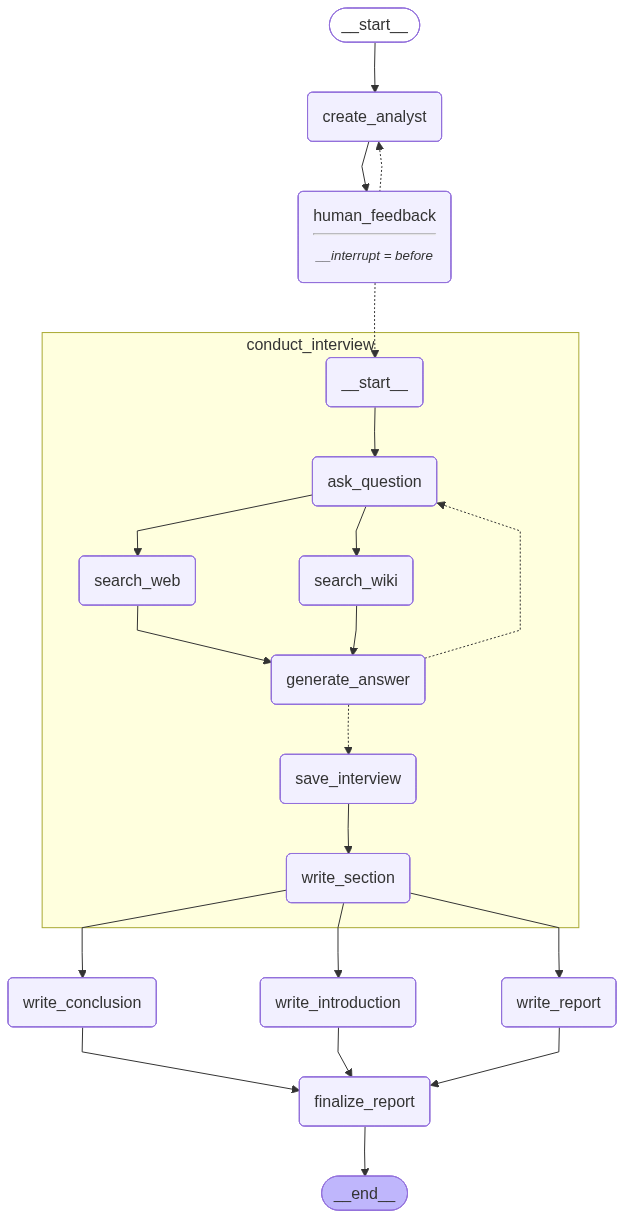

In [211]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [212]:
max_analysts=3
topic = "Pros and Cons of Langgraph Framework for Building AI Agents with respect to other frameworks like AutoGen and CrewAI"

In [213]:
thread ={"configurable":{"thread_id":4}}

In [214]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, particularly in terms of their architectural flexibility and integration capabilities. She is interested in how Langgraph, AutoGen, and CrewAI differ in their ability to adapt to various AI agent requirements and how these differences impact the development process.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: AI Developer
Description: Raj is a hands-on AI developer who evaluates frameworks based on their ease of use and developer support. He is particularly concerned with how Langgraph compares to AutoGen and CrewAI in terms of documentation, community support, and the learning curve for new developers.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Global AI Ethics Consortium
Role: AI Ethics Specialist
Description:

In [215]:
graph.update_state(
    thread,
    {"human_analyst_feedback": "Add something about production grade issues like latency, scalability, and robustness."},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b74bd-6ecd-681e-8002-ba592d3bca9c'}}

In [216]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, particularly in terms of their architectural flexibility and integration capabilities. She is interested in how Langgraph, AutoGen, and CrewAI differ in their ability to adapt to various AI agent requirements and how these differences impact the development process.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: AI Developer
Description: Raj is a hands-on AI developer who evaluates frameworks based on their ease of use and developer support. He is particularly concerned with how Langgraph compares to AutoGen and CrewAI in terms of documentation, community support, and the learning curve for new developers.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Global AI Ethics Consortium
Role: AI Ethics Specialist
Description:

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Tech Performance Institute
Role: AI Framework Performance Analyst
Description: Dr. Chen focuses on evaluating the performance metrics of AI frameworks, particularly in terms of latency and scalability. She is interested in how Langgraph compares to AutoGen and CrewAI in handling large-scale AI agent deployments, and the implications of these differences for real-time applications.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global AI Systems
Role: AI Systems Reliability Engineer
Description: Raj is dedicated to assessing the robustness and reliability of AI frameworks. His primary concern is how Langgraph ensures stability and error handling compared to AutoGen and CrewAI, especially in production environments where robustness is critical.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: InnovateAI Solutions
Role: AI Development Strategist
Description: Sophia analyzes the strategi

In [217]:
graph.update_state(
    thread,
    {"human_analyst_feedback": ""},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b74c0-f59f-6c2c-8006-7b7364521069'}}

In [218]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [219]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph vs AutoGen vs CrewAI AI frameworks comparison pros and cons integration development flexibility'
*******************************
search_query='Langgraph framework stability error handling comparison with AutoGen CrewAI production environments'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph vs AutoGen vs CrewAI latency performance large-scale AI agent deployments'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph error recovery mechanisms case study production environment comparison with AutoGen CrewAI'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='LangGraph framework advantages over AutoGen and CrewAI in complex AI projects'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph vs AutoGen vs CrewAI latency performance large-scale AI agent deployments case study'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
conduct_interview
--Node--
conduct_interview


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
conduct_interview


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
write_conclusion


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
write_introduction


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
write_report
--Node--
finalize_report


In [220]:
final_state = graph.get_state(thread)

In [221]:
report = final_state.values.get("final_report","")

In [222]:
Markdown(report)

# Navigating the AI Framework Landscape: LangGraph, AutoGen, and CrewAI

## Introduction

In the rapidly evolving landscape of AI frameworks, selecting the right system is crucial for optimizing performance and scalability in large-scale AI agent deployments. This report provides a comprehensive evaluation of three prominent frameworks: LangGraph, AutoGen, and CrewAI. LangGraph, with its graph-based orchestration, excels in complex, stateful workflows but may introduce latency challenges. AutoGen offers dynamic, conversation-centric capabilities, ideal for enterprise-scale projects, yet requires robust management strategies. CrewAI, with its role-based model, provides simplicity and speed for smaller projects but lacks advanced tooling. Understanding these frameworks' strengths and limitations is essential for effective AI system design and deployment.

---



In the rapidly evolving landscape of AI frameworks, selecting the right system for building AI agents is crucial for optimizing performance, scalability, and reliability. This report synthesizes insights from expert analyses of three prominent AI frameworks: LangGraph, AutoGen, and CrewAI, each offering distinct advantages and challenges in multi-agent orchestration.

LangGraph is a graph-based extension of LangChain, designed for stateful multi-agent flows. It excels in scenarios where workflows can be represented as graphs, providing precise control over agent interactions. This framework is particularly beneficial for complex, enterprise-grade applications that demand high reliability and advanced orchestration capabilities. LangGraph's state-centric orchestration framework enhances coordination and performance, making it suitable for complex systems. Its robust error recovery features, such as conditional edges and retry strategies, ensure that workflows can recover gracefully from failures, reducing software maintenance costs by 15% [1][2]. However, its abstractions can add overhead, potentially increasing latency with each additional agent or tool [1][2]. Despite these challenges, LangGraph's built-in caching and persistence layer improve performance by reusing previously computed results [3]. The framework requires a higher upfront investment in terms of setup and learning, which can be a barrier for teams seeking rapid deployment [1].

AutoGen, developed by Microsoft, is a conversation-centric framework aimed at scalable multi-agent orchestration. It supports horizontal scaling through conversation sharding and distributed chat management, though maintaining conversation context can be challenging. AutoGen is explicitly designed for enterprise-scale projects, offering robust capabilities for dynamic multi-agent collaboration [1][2]. Its caching API requests further enhance performance by reducing latency [3]. AutoGen reduces error rates by 35% through automated testing and validation features [2]. However, its dynamic nature can lead to unpredictable interactions, necessitating robust conversation management strategies and close monitoring in production environments [1]. While AutoGen offers maximum flexibility, this often comes at the cost of stability, making it less enterprise-friendly compared to its counterparts [3]. Its minimal coding requirements enable faster deployment, which is advantageous for teams focusing on customer-facing applications [1]. Despite its ease of use, AutoGen may struggle with maintaining global state consistency, complicating more intricate workflows [5].

CrewAI is a high-level, lightweight Python framework focused on role-based agents. It scales through horizontal agent replication and task parallelization within role hierarchies. CrewAI's minimal abstraction allows for concurrency by default, making it fast in simple use cases. However, it lacks advanced load-balancing and mature tooling, which can complicate production use [1][2]. Despite these limitations, CrewAI's structured memory management simplifies context management, making it suitable for small to medium projects [4]. CrewAI prioritizes structured reliability with its role-based model, achieving a 92% accuracy rate in query resolution [2]. Its microservices architecture allows for significant scalability while maintaining system stability. CrewAI's approach to error handling involves pragmatic isolation, which, while effective, may not offer the same level of deterministic recovery as LangGraph [3]. Nonetheless, CrewAI's structured pipelines ensure higher reliability and reproducibility, making it a strong choice for enterprises running automation at scale [3]. This framework is user-friendly and offers extensive customization options, making it suitable for role-based prototyping and structured task execution [1][3]. However, its adaptability in rapidly changing environments is limited, and it may require additional effort for customization as business needs evolve [1].

The choice between these frameworks depends on the specific requirements of the deployment. LangGraph is ideal for structured, graph-based workflows requiring robust error handling. AutoGen excels in dynamic conversational environments, while CrewAI is best for role-based agent teamwork. Understanding these differences is essential for developers to design, manage, and scale their systems effectively. Prototyping with each framework is recommended to understand how they handle specific requirements and to ensure the selection of the most suitable framework for optimizing both development and operational efficiency [2].


---

## Conclusion

In the rapidly evolving landscape of AI frameworks, selecting the right tool is crucial for optimizing performance and reliability. LangGraph, with its state-centric orchestration and robust error recovery, is ideal for complex, mission-critical workflows. AutoGen excels in dynamic conversational environments, offering flexibility and scalability, though it may require careful management to maintain stability. CrewAI's role-based model provides structured reliability and ease of use, making it suitable for small to medium projects. Each framework presents unique strengths and trade-offs, emphasizing the importance of aligning framework capabilities with project requirements to ensure strategic success and operational efficiency.

## Sources
[1] https://latenode.com/blog/langgraph-vs-autogen-vs-crewai-complete-ai-agent-framework-comparison-architecture-analysis-2025  
[2] https://sparkco.ai/blog/langgraph-vs-crewai-vs-autogen-2025-production-showdown  
[3] https://medium.com/@kanerika/crewai-vs-autogen-a-complete-comparison-of-multi-agent-ai-frameworks-3d2cec907231  
[4] https://deepfa.ir/en/blog/open-source-ai-agent-frameworks-comparison  
[5] https://blog.promptlayer.com/langgraph-vs-autogen/  
[6] https://scalexi.medium.com/comparing-llm-agent-frameworks-langgraph-vs-autogen-vs-crew-ai-part-i-92234321eb6b